<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/code/SV/5S/SV_unet_extract_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
%cd drive/My\ Drive/

/content/drive/My Drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import *

## Load model

In [5]:
class UNet(nn.Module):

    def __init__(self):
        super(UNet, self).__init__()

        self.threshold = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 8, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True),
            nn.ReLU()
        )

        self.cnn_input_1 = nn.Sequential(
            nn.BatchNorm1d(8+2),
            nn.Conv1d(8+2, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.pooling_1 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 5, stride = 2, padding = 2, dilation = 1)
        )

        self.cnn_input_2 = nn.Sequential(
            nn.BatchNorm1d(8),
            nn.Conv1d(8, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.pooling_2 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 5, stride = 2, padding = 2, dilation = 1)
        )

        self.cnn_input_3 = nn.Sequential(
            nn.BatchNorm1d(16),
            nn.Conv1d(16, 32,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(32, 32,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.upconv_2 = nn.Sequential(
             nn.ConvTranspose1d(32, 16, kernel_size = 6, stride = 2, padding = 2, dilation = 1)
         )

        self.cnn_output_2 = nn.Sequential(
            nn.BatchNorm1d(16*2),
            nn.Conv1d(16*2, 16,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 16,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.upconv_1 = nn.Sequential(
             nn.ConvTranspose1d(16, 8, kernel_size = 6, stride = 2, padding = 2, dilation = 1)
         )
        
        self.cnn_output_1 = nn.Sequential(
            nn.BatchNorm1d(8*2),
            nn.Conv1d(8*2, 8,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 4, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(4, 2, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(2, 1,  kernel_size = 5, stride = 1, padding = 2, dilation = 1)
        )

    def forward(self, x, y):
        out = self.threshold(y)
        out = torch.sum(out, 2)

        out = torch.cat((out, x.squeeze(1)), 1)

        out_1 = self.cnn_input_1(out)
        out = self.pooling_1(out_1)
        out_2 = self.cnn_input_2(out)
        out = self.pooling_2(out_2)
        out = self.cnn_input_3(out)

        out = self.upconv_2(out)
        out = torch.cat((out, out_2), 1)
        out = self.cnn_output_2(out)

        out = self.upconv_1(out)
        out = torch.cat((out, out_1), 1)
        out = self.cnn_output_1(out)


        return out

In [6]:
model = torch.load('SV_unet_matrixlonlat_5s.pt')
window = 20
variable = ('lon_std', 'lat_std')

# Test

In [7]:
data_test = pd.read_csv('./data/SV_test.csv')

resolution = 5
data_new = change_resolution(data_test, resolution)
data_new = standardize_data(data_new)

data_new.head()

,trip,datetime,lon,lat,gaps,dive,step_speed,step_direction,lon_std,lat_std,step_speed_std,step_direction_cos,step_direction_sin
2,P1108_6_SV_T2,2008-11-25 21:03:25,-77.264393,-11.770143,0.0,0,15.618553,-4.458985,1.691276,0.797684,0.752478,0.996973,-0.077745
3,P1108_6_SV_T2,2008-11-25 21:03:30,-77.264937,-11.769742,0.0,0,14.841292,-22.123529,1.683857,0.802135,0.713763,0.926374,-0.376605
4,P1108_6_SV_T2,2008-11-25 21:03:35,-77.265407,-11.769267,0.0,0,14.722446,8.933298,1.677448,0.807408,0.707844,0.987870,0.155285
5,P1108_6_SV_T2,2008-11-25 21:03:40,-77.266028,-11.768765,0.0,0,17.552105,-6.364142,1.668979,0.812980,0.848787,0.993837,-0.110847
6,P1108_6_SV_T2,2008-11-25 21:03:45,-77.266380,-11.767972,0.0,0,19.248972,26.964911,1.664179,0.821782,0.933307,0.891284,0.453445


In [9]:
# create dataset for a trajectory
t = data_new[data_new.trip == 'P1108_6_SV_T2'].copy()    
test_set = TrajDataSet(t, window, variable, transform = ToTensor())
weight = torch.FloatTensor([30])
criterion = nn.BCEWithLogitsLoss(pos_weight = weight)

# Test the model
list_out = []
list_loss = []
model.eval()
k = 0
with torch.no_grad():
    for (x, y, z) in test_set:

        # Run the forward pass
        out = model(x, y.unsqueeze(1))
        loss = criterion(out.squeeze(1), z)

        list_loss.append(loss.item())
        list_out.append(1/(1+np.exp(-out.squeeze().numpy())))

(array([1.196e+03, 2.370e+02, 2.700e+01, 4.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.07572076e-03, 6.21836641e-01, 1.24259756e+00, 1.86335848e+00,
        2.48411940e+00, 3.10488032e+00, 3.72564124e+00, 4.34640216e+00,
        4.96716308e+00, 5.58792400e+00, 6.20868492e+00]),
 <a list of 10 Patch objects>)

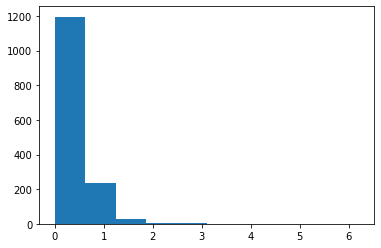

In [10]:
plt.hist(list_loss)

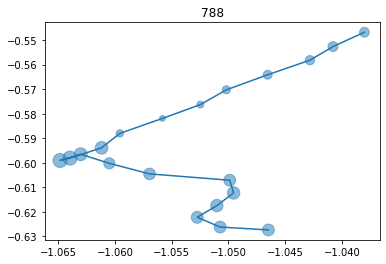

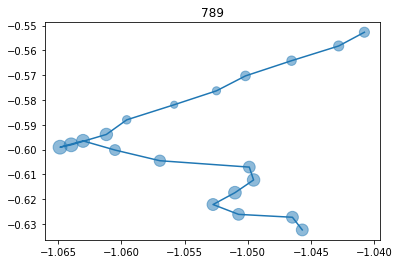

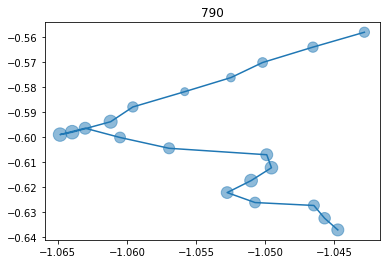

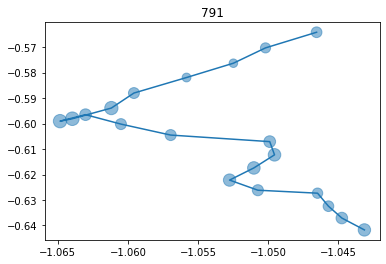

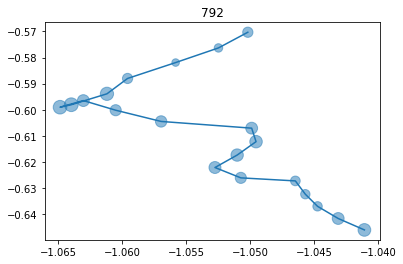

In [48]:
i = 0
for (x, y, z) in test_set:
    lon = x.squeeze().numpy()[0,:]
    lat = x.squeeze().numpy()[1,:]
    dive = (z.squeeze().numpy() == 1)

    if (list_loss[i]>1) & (np.sum(dive)==0) :

      col = ['#d62728' if d>0 else '#1f77b4' for d in dive]

      plt.figure()
      plt.plot(lon, lat)
      plt.scatter(lon, lat, s = 10 + 200*list_out[i], c = col, alpha = 0.5)
      # plt.scatter(lon[dive], lat[dive], c='#d62728', marker = 's')
      plt.title(i)
      plt.show()

    i+=1

In [56]:
idx = [27,913, 437, 789]

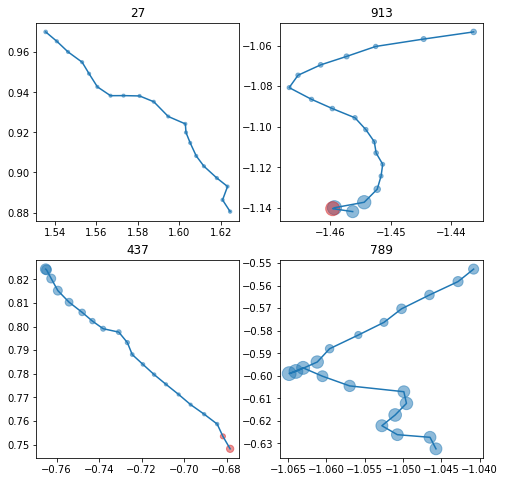

In [57]:
plt.figure(figsize = (8,8))

k = 1
for i in idx:

    x,y,z = test_set[i]
    
    lon = x.squeeze().numpy()[0,:]
    lat = x.squeeze().numpy()[1,:]
    dive = (z.squeeze().numpy() == 1)

    col = ['#d62728' if d>0 else '#1f77b4' for d in dive]

    plt.subplot(2,2,k)
    plt.plot(lon, lat)
    plt.scatter(lon, lat, s = 10 + 200*list_out[i], c = col, alpha = 0.5)
    # plt.scatter(lon[dive], lat[dive], c='#d62728', marker = 's')
    plt.title(i)

    k+=1